# Document Classification

# Installing Libraries

In [1]:
! pip install transformers # transformer libraries from huggingface

     |████████████████████████████████| 2.6 MB 7.9 MB/s 
     |████████████████████████████████| 3.3 MB 55.3 MB/s 
     |████████████████████████████████| 636 kB 47.4 MB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Importing Libraries

In [2]:
import os
import datetime
import json
import ast
import random
import numpy as np
import pandas as pd
import torch
import seaborn
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, AdamW

# Initialize the random number generator.
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
tGenerator = torch.Generator()
tGenerator.manual_seed(42)
def seed_worker(worker_id):
  random.seed(42)
  np.random.seed(42)

# Define the available device.
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.device(device)

device(type='cuda')

# Downloading Datasets

In [3]:
# Download filtered_indosum.tar.gz.
os.system("gdown https://drive.google.com/uc?id=1RbsRMjXplaGTLMdk_vfa5b47gnZHg2y3")
# Extracting filtered_indosum.tar.gz.
! tar -xvf filtered_indosum.tar.gz
! rm filtered_indosum.tar.gz

filtered_indosum/
filtered_indosum/test.05.jsonl
filtered_indosum/test.02.jsonl
filtered_indosum/train.02.jsonl
filtered_indosum/train.04.jsonl
filtered_indosum/train.05.jsonl
filtered_indosum/test.03.jsonl
filtered_indosum/train.01.jsonl
filtered_indosum/dev.04.jsonl
filtered_indosum/test.01.jsonl
filtered_indosum/dev.05.jsonl
filtered_indosum/dev.01.jsonl
filtered_indosum/dev.02.jsonl
filtered_indosum/dev.03.jsonl
filtered_indosum/test.04.jsonl
filtered_indosum/train.03.jsonl


In [4]:
# Download summaries-bert2bert.tsv.
os.system('gdown https://drive.google.com/uc?id=1F5-3hl90ipuYYAxT64_GyrB6103Smr7-')

0

# Preprocessing Functions

In [5]:
def readSummary():
  """
  This function reads summaries from summaries-bert2bert.tsv file.
  returns articleDict (unique articles indexed by article ID).
  """

  articleDf = pd.read_csv("summaries-bert2bert.tsv", sep="\t")
  articleDict = {}
  for index, row in articleDf.iterrows():
    articleDict[row["id"]] = row["summary"]
  
  return articleDict

In [6]:
def loadDataset(type, k, strategy):
  """
  This function loads dataset.
  type: "train", "dev", or "test".
  k: 1, 2, 3, 4, 5.
  strategy: "take-all", "70first", "70middle", "70last", "35first-35middle", "35first-35last", "35middle-35last", "30first-20middle-20last", "summaryExt", "summaryAbs", "summaryAuto".
  returns articles, labels.
  """

  categoryIdDict = {"tajuk utama":0, "olahraga":1, "showbiz":2, "teknologi":3, "hiburan":4, "inspirasi":5}
  articles = []
  labels = []

  if strategy.startswith("summaryAuto"): # If the strategy is auto summarization, then read the data from summaries-bert2bert.tsv file.
    summaryDict = readSummary()

  with open(f"filtered_indosum/{type}.0{k}.jsonl") as lines: # Read "Filtered-IndoSum".
    for line in lines: # Loop over the lines.
      jsonObj = json.loads(line) # Convert json to be object.
      article = []

      # If the strategy is human-annotated abtractive summarization.
      if strategy.startswith("summaryAbs"):
        for sentence in jsonObj["summary"]: # Loop over sentences of abstractive summary.
          article.extend(sentence) # Then pool the sentences in an article.

      # If the strategy is human-annotated extractive summarization.
      elif strategy.startswith("summaryExt"):
        for paragraph, isSummarys in zip(jsonObj["paragraphs"], jsonObj["gold_labels"]): # Loop over paragraph.
          for sentence, isSummary in zip(paragraph, isSummarys): # Loop over Sentence.
            if isSummary == True or isSummary == "True" or isSummary == 1: # If it is a label of extractive summary.
              article.extend(sentence) # Then pool the sentences in an article.

      # If the strategy is auto summarization.
      elif strategy.startswith("summaryAuto"):
        article = summaryDict[jsonObj["id"]] # Then set the article variable with the value of summary.

      # If the strategy is truncation.
      else:
        # BEGIN: Pooling the sentences in an article variable.
        for paragraph in jsonObj["paragraphs"]: # Loop over paragraph.
          for sentence in paragraph: # Loop over Sentence.
            article.extend(sentence) # Pool the sentence.
        # END: Pooling the sentences in an article variable.

        # Then, truncate the article.
        if strategy == "70first":
          article = article[0:70]
        elif strategy == "70middle":
          length = len(article)
          start = int(length/2) - int(70/2)
          article = article[start:start+70]
        elif strategy == "70last":
          length = len(article)
          article = article[length-70:length]
        elif strategy == "35first-35middle":
          length = len(article)
          start = int(length/2) - int(35/2)
          firstPart = article[0:35]
          middlePart = article[start:start+35]
          article = firstPart + middlePart
        elif strategy == "35first-35last":
          length = len(article)
          firstPart = article[0:35]
          lastPart = article[length-35:length]
          article = firstPart + lastPart
        elif strategy == "35middle-35last":
          length = len(article)
          start = int(length/2) - int(35/2)
          middlePart = article[start:start+35]
          lastPart = article[length-35:length]
          article = middlePart + lastPart
        elif strategy == "30first-20middle-20last":
          length = len(article)
          start = int(length/2) - int(20/2)
          firstPart = article[0:30]
          middlePart = article[start:start+20]
          lastPart = article[length-20:length]
          article = firstPart + middlePart + lastPart
          
      articles.append(article) # Pool the articles in an array.
      labels.append(categoryIdDict[jsonObj["category"]]) # Pool the classification labels in an array.

  return articles, labels

In [7]:
def preprocess(k, tokenizer, strategy="take-all"):
  """
  This function does preprocessing.
  k: 1, 2, 3, 4, 5.
  strategy: "take-all", "70first", "70middle", "70last", "35first-35middle", "35first-35last", "35middle-35last", "30first-20middle-20last", "summaryExt", "summaryAbs", "summaryAuto".
  returns datasetTrain, datasetVal, datasetTest.
  """
  print(f"Fold{k} Preprocessing...")

  # BEGIN: Loading dataset.
  articlesTrain, labelsTrain = loadDataset("train", k, strategy)
  articlesVal, labelsVal = loadDataset("dev", k, strategy)
  articlesTest, labelsTest = loadDataset("test", k, strategy)
  # END: Loading dataset.

  # BEGIN: Encoding the data.
  if strategy.startswith("summaryAuto"):
    isSplitIntoWords = False
  else:
    isSplitIntoWords = True

  if strategy == "take-all":
    encodedDataTrain = tokenizer(articlesTrain, is_split_into_words=isSplitIntoWords, padding=True, max_length=512, truncation=True)
    encodedDataVal = tokenizer(articlesVal, is_split_into_words=isSplitIntoWords, padding=True, max_length=512, truncation=True)
    encodedDataTest = tokenizer(articlesTest, is_split_into_words=isSplitIntoWords, padding=True, max_length=512, truncation=True)
  else:
    encodedDataTrain = tokenizer(articlesTrain, is_split_into_words=isSplitIntoWords, padding=True)
    encodedDataVal = tokenizer(articlesVal, is_split_into_words=isSplitIntoWords, padding=True)
    encodedDataTest = tokenizer(articlesTest, is_split_into_words=isSplitIntoWords, padding=True)
  # END: Encoding the data.

  # BEGIN: Converting data to be torch tensor format.
  tensorsTrain = [torch.tensor(encodedDataTrain["input_ids"], dtype=torch.long), 
                torch.tensor(encodedDataTrain["attention_mask"], dtype=torch.long), 
                torch.tensor(labelsTrain, dtype=torch.long)]
  tensorsVal = [torch.tensor(encodedDataVal["input_ids"], dtype=torch.long), 
                  torch.tensor(encodedDataVal["attention_mask"], dtype=torch.long), 
                  torch.tensor(labelsVal, dtype=torch.long)]
  tensorsTest = [torch.tensor(encodedDataTest["input_ids"], dtype=torch.long), 
                  torch.tensor(encodedDataTest["attention_mask"], dtype=torch.long), 
                  torch.tensor(labelsTest, dtype=torch.long)]
  # END: Converting data to be torch tensor format.
  
  # BEGIN: Wrapping as TensorDataset.
  datasetTrain = TensorDataset(*tensorsTrain)
  datasetVal = TensorDataset(*tensorsVal)
  datasetTest = TensorDataset(*tensorsTest)
  # END: Wrapping as TensorDataset.

  print(f"Fold{k} Preprocessing Finished!")
  return datasetTrain, datasetVal, datasetTest

# Fine-Tuning Functions

In [8]:
def drawHistory(trainLosses, valLosses, valAccuracies, valF1Scores):
  """
  This function draws training history as line graphs.
  """
  plt.figure(figsize=(20,5))
  
  plt.subplot(1, 4, 1)
  plt.plot(trainLosses, label="train loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss")
  plt.legend()
  plt.xticks(np.arange(0, 5))

  plt.subplot(1, 4, 2)
  plt.plot(valLosses, label="val loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Validation Loss")
  plt.legend()
  plt.xticks(np.arange(0, 5))

  plt.subplot(1, 4, 3)
  plt.plot(valAccuracies, label="val acc")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Validation Accuracy")
  plt.legend()
  plt.xticks(np.arange(0, 5))

  plt.subplot(1, 4, 4)
  plt.plot(valF1Scores, label="val f1")
  plt.xlabel("Epoch")
  plt.ylabel("F1-Score")
  plt.title("Validation F1-Score")
  plt.legend()
  plt.xticks(np.arange(0, 5))

  plt.show()

In [9]:
def train(model, trainDataLoader, optimizer):
  """
  This function trains a model using training data.
  returns loss info.
  """
  model.train() # Set the model as training mode.

  trainLoss = 0 # Cumulative loss.

  for batch in trainDataLoader: # Loop over batches.
    model.zero_grad() # Re-init new gradient for every loop.

    # Unpacking data, moving to GPU if available.
    inputIds = batch[0].to(device)
    attentionMasks = batch[1].to(device)
    labels = batch[2].to(device)

    outputs = model(inputIds, attention_mask=attentionMasks, labels=labels) # Feed forward.
    loss = outputs.loss # By default it uses Categorical Cross Entropy as loss function.
    trainLoss += loss.item() # Getting loss info.
    
    loss.backward() # Back-propagation. Computing gradient.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # OPTIONAL. Gradient clipping to avoid exploding gradient.
    optimizer.step() # Updating parameters.

  model.eval() # IMPORTANT! Set the model as evaluation mode.
  return trainLoss / len(trainDataLoader) # Need to average, because it is batch processing.

In [10]:
def validate(model, valDataLoader):
  """
  This function evaluates a model using evaluation data.
  returns loss, accuracy, and f1-score info.
  """
  model.eval() # IMPORTANT! Set the model as evaluation mode.

  predictions = []
  targets = []
  bestScore = 0
  loss = 0 # Cumulative loss.

  for batch in valDataLoader: # Loop over batches.
    # Unpacking data, moving to GPU if available.
    inputIds = batch[0].to(device)
    attentionMasks = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad(): # IMPORTANT! Do not compute gradient!
      outputs = model(inputIds, attention_mask=attentionMasks, labels=labels) # Feed forward.
    
    loss += outputs.loss.item() # Getting loss info.
    logits = outputs.logits.detach().cpu() # Getting logits, moving to CPU.

    preds = torch.argmax(logits, dim=1).numpy() # Getting most probable prediction. No need to softmax.
    labels = labels.detach().cpu().numpy() # Moving to CPU.

    predictions.extend(preds)
    targets.extend(labels)

  # Calculate Evaluation Loss.
  loss = loss / len(valDataLoader) # Need to average, because it is batch processing.

  # Calculate Evaluation Accuracy.
  accuracy = accuracy_score(targets, predictions)

  # Calculate Evaluation F1-Score.
  f1Score = f1_score(targets, predictions, average="macro")

  if f1Score > bestScore:
    bestScore = f1Score
    model.save_pretrained("my-distilbert-classifier") # Save the best model. It produces two files: config.json & pytorch_model.bin.

  return loss, accuracy, f1Score

In [11]:
def fineTune(k, model, datasetTrain, datasetVal):
  """
  This function fine-tunes a model.
  k: 1, 2, 3, 4, or 5.
  """
  startTime = datetime.datetime.now()
  print(f"Fold{k} Fine-Tuning...")
  print("Started at", startTime.strftime("%Y-%m-%d %H:%M:%S"))

  # Hyperparameters
  learningRate = 2e-5
  batchSize = 16
  epochs = 5
  weightDecay = 0 # AdamW default

  # AdamW is the most used optimizer.
  optimizer = AdamW(model.parameters(), lr=learningRate, eps=1e-8, weight_decay=weightDecay)

  # Use DataLoader for batch processing.
  trainDataLoader = DataLoader(datasetTrain, batch_size=batchSize, worker_init_fn=seed_worker, num_workers=0, generator=tGenerator)
  valDataLoader = DataLoader(datasetVal, batch_size=batchSize, worker_init_fn=seed_worker, num_workers=0, generator=tGenerator)

  trainLosses = [] # To pool training loss values.
  valLosses = [] # To pool validation loss values.
  valAccuracies = [] # To pool validation accuracy values.
  valF1Scores = [] # To pool validation f1-score values.

  for epoch in range(1, epochs+1): # Loop epochs.
    # Training the model.
    trainLoss = train(model, trainDataLoader, optimizer)
    trainLosses.append(trainLoss)

    # Evaluating the model.
    valLoss, valAccuracy, valF1Score = validate(model, valDataLoader)
    valLosses.append(valLoss)
    valAccuracies.append(valAccuracy)
    valF1Scores.append(valF1Score)

    print(f"Epoch: {epoch} | loss: {trainLoss} | valLoss: {valLoss} | valAcc: {valAccuracy} | valF1: {valF1Score}")

  # Once finished, draw training & evaluation history.
  drawHistory(trainLosses, valLosses, valAccuracies, valF1Scores)

  endTime = datetime.datetime.now()
  print("Finished at", endTime.strftime("%Y-%m-%d %H:%M:%S"))
  print("Executed in", endTime-startTime)
  print(f"Fold{k} Fine-Tuning Finished!")

# Testing Functions

In [12]:
def testing(k, model, datasetTest):
  """
  This function evaluate a model using testing data.
  k: 1, 2, 3, 4, or 5.
  returns accuracy and f1-score info.
  """
  print(f"Fold{k} Testing...")
  model.eval() # IMPORTANT! Set the model as evaluation mode.

  predictions = []
  targets = []

  # Use DataLoader for batch processing.
  testDataLoader = DataLoader(datasetTest, batch_size=16, worker_init_fn=seed_worker, num_workers=0, generator=tGenerator)

  for batch in testDataLoader: # Loop over batches.
    # Unpacking data, moving to GPU if available.
    inputIds = batch[0].to(device)
    attentionMasks = batch[1].to(device)
    labels = batch[2].numpy() # CPU only

    with torch.no_grad(): # IMPORTANT! Do not compute gradient!
      outputs = model(inputIds, attention_mask=attentionMasks) # Feed forward. Without calculating loss.
    
    logits = outputs.logits.detach().cpu() # Getting logits, moving to CPU.
    preds = torch.argmax(logits, dim=1).numpy() # Getting most probable prediction. No need to softmax.

    predictions.extend(preds)
    targets.extend(labels)

  # Calculate Evaluation Accuracy.
  accuracy = accuracy_score(targets, predictions)

  # Calculate Evaluation F1-Score.
  f1Score = f1_score(targets, predictions, average="macro")

  # Print reporting.
  report = classification_report(targets, predictions)
  print(report)

  print(f"Fold{k} | testAcc: {accuracy} | testF1: {f1Score}")
  print(f"Fold{k} Testing Finished!")
  return accuracy, f1Score

# Running K-Fold Cross Validation

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['pre_classifier.bias', 'pre_classifie

Fold1 Preprocessing...
Fold1 Preprocessing Finished!
Fold1 Fine-Tuning...
Started at 2021-08-30 01:35:02
Epoch: 1 | loss: 0.30903597401006017 | valLoss: 0.2180759102726976 | valAcc: 0.9397590361445783 | valF1: 0.7695225863541825
Epoch: 2 | loss: 0.18991118830135315 | valLoss: 0.24348864319645577 | valAcc: 0.9412650602409639 | valF1: 0.7732115842376062
Epoch: 3 | loss: 0.1419910113961253 | valLoss: 0.264199520760615 | valAcc: 0.9457831325301205 | valF1: 0.858385034104472
Epoch: 4 | loss: 0.1056645684244965 | valLoss: 0.2972643213634867 | valAcc: 0.9397590361445783 | valF1: 0.8493007999798549
Epoch: 5 | loss: 0.07663558250680494 | valLoss: 0.3830449830635362 | valAcc: 0.9337349397590361 | valF1: 0.8420942444160229


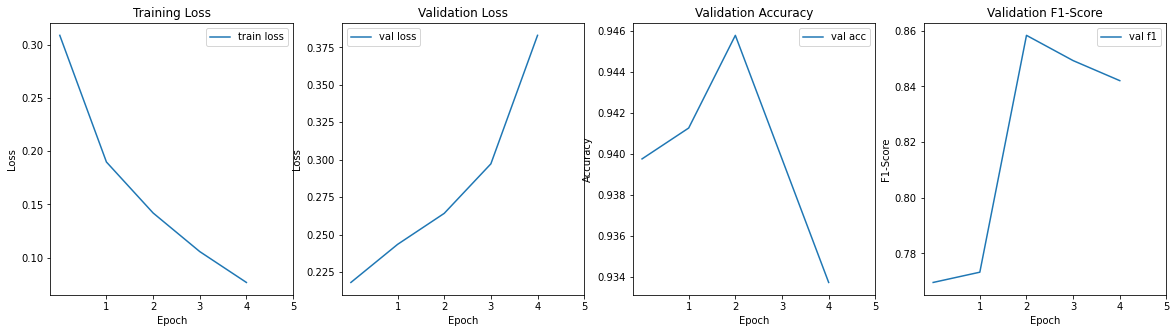

Finished at 2021-08-30 01:59:57
Executed in 0:24:54.821971
Fold1 Fine-Tuning Finished!
Fold1 Testing...
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       794
           1       0.99      0.99      0.99       511
           2       0.94      0.88      0.91       294
           3       0.93      0.95      0.94       240
           4       0.69      0.73      0.71       183
           5       0.40      0.13      0.20        15

    accuracy                           0.92      2037
   macro avg       0.81      0.77      0.78      2037
weighted avg       0.92      0.92      0.92      2037

Fold1 | testAcc: 0.9204712812960235 | testF1: 0.7794803155911048
Fold1 Testing Finished!


Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['pre_classifier.bias', 'pre_classifie

Fold2 Preprocessing...
Fold2 Preprocessing Finished!
Fold2 Fine-Tuning...
Started at 2021-08-30 02:00:43
Epoch: 1 | loss: 0.3021177272942926 | valLoss: 0.2381513267090278 | valAcc: 0.9321266968325792 | valF1: 0.7577293750296462
Epoch: 2 | loss: 0.1840920919331395 | valLoss: 0.2687865527945438 | valAcc: 0.9351432880844646 | valF1: 0.7640527134417119
Epoch: 3 | loss: 0.13473852704624906 | valLoss: 0.3013078578958465 | valAcc: 0.9321266968325792 | valF1: 0.7574975469531164
Epoch: 4 | loss: 0.09767810080059765 | valLoss: 0.34684658369570526 | valAcc: 0.9276018099547512 | valF1: 0.7520631626566324
Epoch: 5 | loss: 0.06748000275911181 | valLoss: 0.4584410544678879 | valAcc: 0.9245852187028658 | valF1: 0.7489166685044325


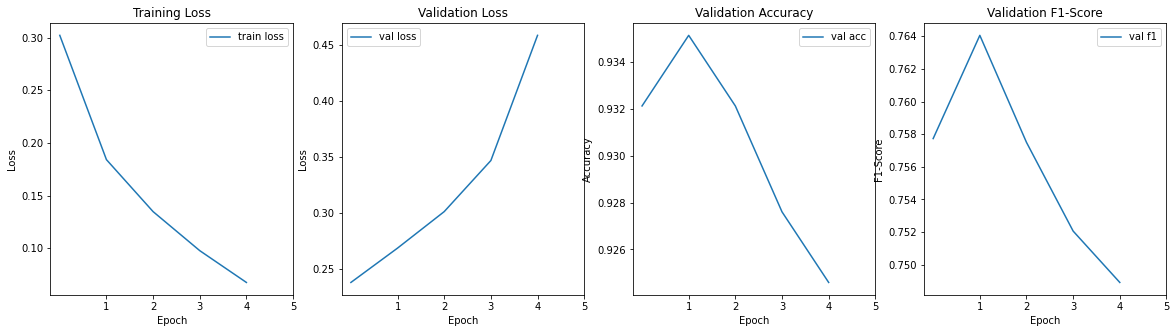

Finished at 2021-08-30 02:25:40
Executed in 0:24:56.365303
Fold2 Fine-Tuning Finished!
Fold2 Testing...
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       794
           1       0.99      0.99      0.99       511
           2       0.89      0.91      0.90       294
           3       0.91      0.93      0.92       240
           4       0.81      0.60      0.69       181
           5       0.62      0.38      0.48        13

    accuracy                           0.92      2033
   macro avg       0.86      0.80      0.82      2033
weighted avg       0.92      0.92      0.92      2033

Fold2 | testAcc: 0.9222823413674373 | testF1: 0.8188929893790529
Fold2 Testing Finished!


Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['pre_classifier.bias', 'pre_classifie

Fold3 Preprocessing...
Fold3 Preprocessing Finished!
Fold3 Fine-Tuning...
Started at 2021-08-30 02:26:26
Epoch: 1 | loss: 0.3156771598505562 | valLoss: 0.16239712828592884 | valAcc: 0.9561270801815431 | valF1: 0.7845755658682582
Epoch: 2 | loss: 0.19671877656363085 | valLoss: 0.17751101893372834 | valAcc: 0.9546142208774584 | valF1: 0.7832390203858718
Epoch: 3 | loss: 0.14247786593076844 | valLoss: 0.1919393412646882 | valAcc: 0.9485627836611196 | valF1: 0.8422115903442452
Epoch: 4 | loss: 0.10112234133099902 | valLoss: 0.23276418844831087 | valAcc: 0.9515885022692889 | valF1: 0.7785190465077793
Epoch: 5 | loss: 0.0706845123745829 | valLoss: 0.3063516498257827 | valAcc: 0.9455370650529501 | valF1: 0.7704858696064916


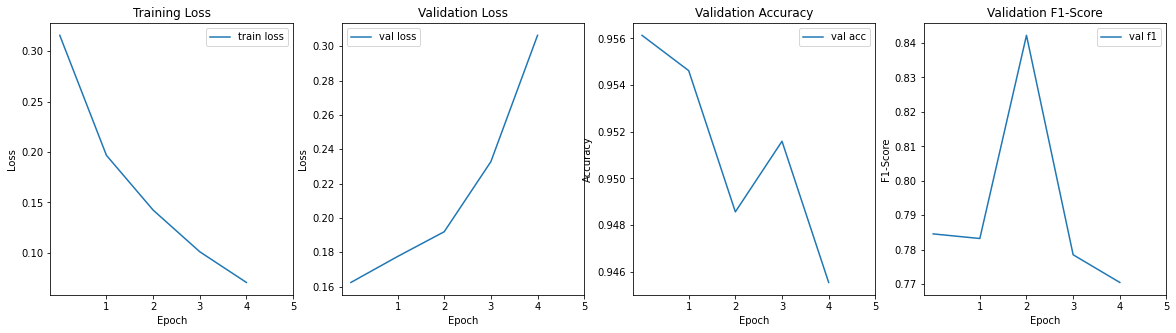

Finished at 2021-08-30 02:51:24
Executed in 0:24:57.821095
Fold3 Fine-Tuning Finished!
Fold3 Testing...
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       792
           1       0.98      0.99      0.99       511
           2       0.94      0.86      0.90       294
           3       0.95      0.93      0.94       239
           4       0.67      0.75      0.71       181
           5       0.17      0.08      0.11        13

    accuracy                           0.92      2030
   macro avg       0.78      0.76      0.77      2030
weighted avg       0.92      0.92      0.92      2030

Fold3 | testAcc: 0.9246305418719212 | testF1: 0.7652461204813968
Fold3 Testing Finished!


Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['pre_classifier.bias', 'pre_classifie

Fold4 Preprocessing...
Fold4 Preprocessing Finished!
Fold4 Fine-Tuning...
Started at 2021-08-30 02:52:10
Epoch: 1 | loss: 0.30009655390117446 | valLoss: 0.23985879174211905 | valAcc: 0.9287878787878788 | valF1: 0.7463396255458999
Epoch: 2 | loss: 0.19114650272934477 | valLoss: 0.2669392050177391 | valAcc: 0.9287878787878788 | valF1: 0.8182277128577463
Epoch: 3 | loss: 0.14098462238330062 | valLoss: 0.3335078784841157 | valAcc: 0.9166666666666666 | valF1: 0.8206048875594555
Epoch: 4 | loss: 0.10408687080224813 | valLoss: 0.3117716307058886 | valAcc: 0.9333333333333333 | valF1: 0.8615264458904895
Epoch: 5 | loss: 0.07421237655631979 | valLoss: 0.3729668893391222 | valAcc: 0.9272727272727272 | valF1: 0.8517907275816518


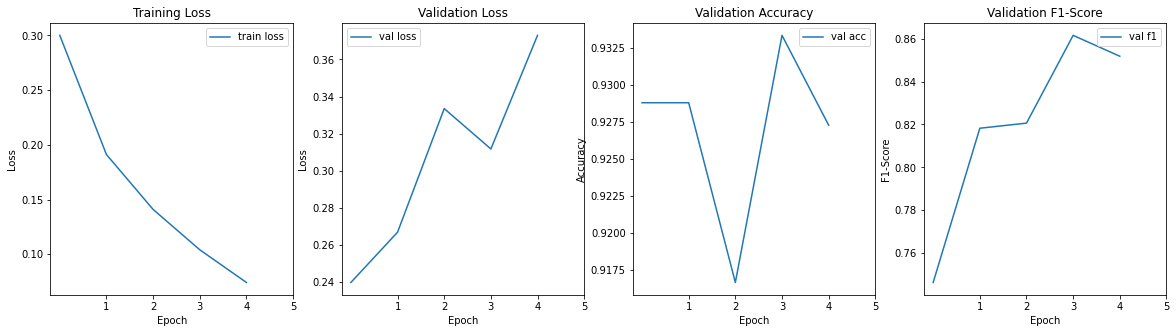

Finished at 2021-08-30 03:17:09
Executed in 0:24:59.296392
Fold4 Fine-Tuning Finished!
Fold4 Testing...
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       790
           1       0.99      0.97      0.98       511
           2       0.89      0.93      0.91       292
           3       0.94      0.94      0.94       238
           4       0.84      0.64      0.72       179
           5       0.25      0.15      0.19        13

    accuracy                           0.92      2023
   macro avg       0.80      0.77      0.78      2023
weighted avg       0.92      0.92      0.92      2023

Fold4 | testAcc: 0.9233811171527434 | testF1: 0.7798111554843327
Fold4 Testing Finished!


Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['pre_classifier.bias', 'pre_classifie

Fold5 Preprocessing...
Fold5 Preprocessing Finished!
Fold5 Fine-Tuning...
Started at 2021-08-30 03:17:55
Epoch: 1 | loss: 0.3074925841780197 | valLoss: 0.2204476546363107 | valAcc: 0.9409090909090909 | valF1: 0.7705131541053115
Epoch: 2 | loss: 0.19254836200761336 | valLoss: 0.229768349789083 | valAcc: 0.946969696969697 | valF1: 0.7757521632069135
Epoch: 3 | loss: 0.1439230001610303 | valLoss: 0.28334956519704846 | valAcc: 0.9348484848484848 | valF1: 0.7634625716079082
Epoch: 4 | loss: 0.10177217911962055 | valLoss: 0.27723754284670576 | valAcc: 0.9454545454545454 | valF1: 0.7760810968017928
Epoch: 5 | loss: 0.06977409025430002 | valLoss: 0.3386043049977161 | valAcc: 0.9393939393939394 | valF1: 0.768207902629455


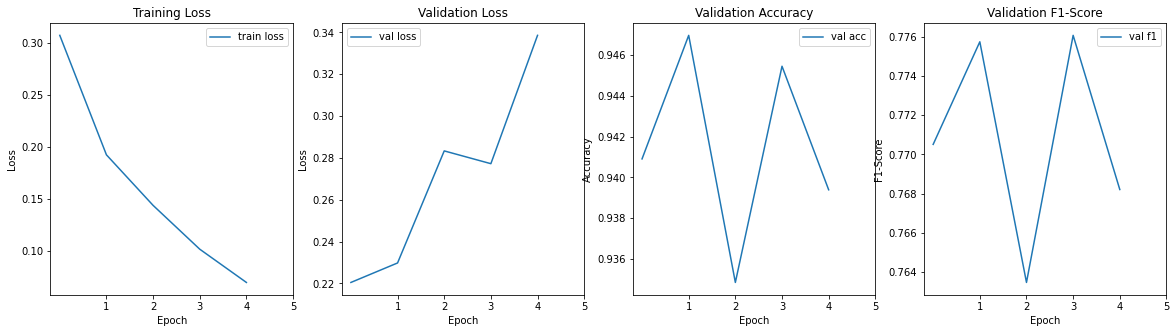

Finished at 2021-08-30 03:42:55
Executed in 0:25:00.367396
Fold5 Fine-Tuning Finished!
Fold5 Testing...
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       790
           1       0.98      0.99      0.98       510
           2       0.90      0.90      0.90       290
           3       0.94      0.94      0.94       237
           4       0.73      0.78      0.76       178
           5       0.45      0.42      0.43        12

    accuracy                           0.93      2017
   macro avg       0.83      0.83      0.83      2017
weighted avg       0.93      0.93      0.93      2017

Fold5 | testAcc: 0.9291026276648487 | testF1: 0.8273797833147195
Fold5 Testing Finished!
Accuracy: 0.9239735818705949
F1-Score: 0.7941620728501213


In [13]:
"""
Choose your strategy.
"""
# take-all, 70first, 70middle, 70last, 
# 35first-35middle, 35first-35last, 35middle-35last, 30first-20middle-20last,
# summaryExt, summaryAbs, summaryAuto.
strategy = "take-all" # Replace with the preferred one.

"""
Define which fold(s) to run.
"""
startFold = 1
folds = 5

"""
Loading Tokenizer.
"""
tokenizer = DistilBertTokenizerFast.from_pretrained("cahya/distilbert-base-indonesian")
print("==================================================")

"""
Running the main part.
"""
accuracies = []
f1Scores = []

for k in range(startFold, startFold+folds): # Loop over k.
  # Loading Fresh Pretrained Model (for every new k).
  model = DistilBertForSequenceClassification.from_pretrained("cahya/distilbert-base-indonesian", num_labels=6)
  model.to(device) # Moving into GPU if available.
  print("==================================================")
  
  # Preprocessing.
  datasetTrain, datasetVal, datasetTest = preprocess(k, tokenizer, strategy)
  
  # Fine-Tuning the Model.
  fineTune(k, model, datasetTrain, datasetVal)

  # Loading the Best (Saved) Model.
  model = DistilBertForSequenceClassification.from_pretrained("my-distilbert-classifier")
  model.to(device) # Send to GPU if available.

  # Testing the Best Model
  accuracy, f1Score = testing(k, model, datasetTest)
  accuracies.append(accuracy)
  f1Scores.append(f1Score)

  print("==================================================")

print(f"Accuracy: {np.average(accuracies)}")
print(f"F1-Score: {np.average(f1Scores)}")